# Pkg Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Setting up  Environments 

In [15]:
sns.set(style='darkgrid', context='talk', palette='rainbow', font_scale=1)


### loading Dataset ...

In [16]:
dataset_url='https://archive.ics.uci.edu/static/public/165/data.csv'

dataframe = pd.read_csv(dataset_url)

dataframe.columns = [str(col).strip() for col in dataframe.columns]

print(f'Dtaset Size {dataframe.shape}, Row count {dataframe.shape[0]} , feature count {dataframe.shape[1]}')

dataframe.head()

Dtaset Size (1030, 9), Row count 1030 , feature count 9


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### Null Analysis

In [17]:
dataframe.isna().sum()

Cement                           0
Blast Furnace Slag               0
Fly Ash                          0
Water                            0
Superplasticizer                 0
Coarse Aggregate                 0
Fine Aggregate                   0
Age                              0
Concrete compressive strength    0
dtype: int64

### Duplicate Removal

In [18]:
dup_data = dataframe[dataframe.duplicated(keep='first')]
print(f'Duplicate Count {dup_data.shape[0]}')
if not dup_data.empty:
    dataframe.drop_duplicates(keep='first', inplace=True)
    dup_data = dataframe[dataframe.duplicated(keep='first')]
    print(f'Duplicate Count after Duplicate Remover {dup_data.shape[0]}')



Duplicate Count 25
Duplicate Count after Duplicate Remover 0


### Outlier Removal


In [19]:
target_col = 'Concrete compressive strength'
outlier_thre = 75
dataframe = dataframe[dataframe[target_col]< outlier_thre]

print(f'Dtaset Size {dataframe.shape}, Row count {dataframe.shape[0]} , feature count {dataframe.shape[1]}')


Dtaset Size (994, 9), Row count 994 , feature count 9


### Target Column seperation

In [20]:
data_x = dataframe.copy(deep=True)
data_y = data_x.pop(target_col)

print(f'data_x Size {data_x.shape}, Row count {data_x.shape[0]} , feature count {data_x.shape[1]}')

print(f'data_y Size {data_y.shape}')


data_x Size (994, 8), Row count 994 , feature count 8
data_y Size (994,)


### Modeling ....

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


models = [
          ('Liner', LinearRegression(n_jobs=-1)), 
          ('RIDGE', Ridge(random_state=43)),
          ('LASSO', Lasso(random_state=43)), 
          ('KNN', KNeighborsRegressor(n_jobs=-1)),
          ('DecisionTree', DecisionTreeRegressor(random_state=43)),
          ('RandomForest', RandomForestRegressor(random_state=43,n_jobs=-1 ))
        ]
artifacts = []
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']

In [22]:
from dataclasses import dataclass, field
from typing import Any,Dict, List

@dataclass
class Artifact:
    
    name: str
    model: Any
    cv_results: Dict[str, List[float]] = field(default_factory=dict)
        
    
    @property
    def mae(self) -> float:
        test_neg_mae = self.cv_results.get('test_neg_mean_absolute_error', [0])
        return -1 * np.average(test_neg_mae)
    
    @property
    def mse(self)-> float:
        test_neg_mse = self.cv_results.get('test_neg_mean_squared_error', [0])
        return -1 * np.average(test_neg_mse)
    
    @property
    def rmse(self)-> float:
        test_neg_rmse = self.cv_results.get('test_neg_root_mean_squared_error', [0])
        return -1 * np.average(test_neg_rmse)
    
    @property
    def r2(self)-> float:
        test_r2 = self.cv_results.get('test_r2', [0])
        return np.average(test_r2)
    
    @property
    def as_dataframe(self):
        df = pd.DataFrame(self.cv_results)
        df['model'] = self.name
        return df


In [56]:
from sklearn.model_selection import KFold, cross_validate

kfold = KFold(n_splits=5, shuffle=True, random_state=90210)

        
for name_t, model_t in models:
    cv_results_t = cross_validate(model_t, 
                                  data_x, 
                                  data_y, 
                                  cv=kfold, 
                                  scoring=scoring, 
                                  n_jobs=-1, 
                                  return_estimator =True, 
                                  verbose=1)
    artifacts.append(Artifact(name=name_t,model=cv_results_t.estimator,cv_results=cv_results_t))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


AttributeError: 'dict' object has no attribute 'estimator'

In [54]:
artifacts[0].cv_results

{'fit_time': array([0.0036025 , 0.00020647, 0.        , 0.        , 0.        ]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_neg_mean_absolute_error': array([-7.56901369, -7.98493825, -8.73324917, -7.70187056, -8.67446988]),
 'test_neg_mean_squared_error': array([ -95.54073222,  -99.95678559, -117.34123667,  -91.12750585,
        -112.09902963]),
 'test_neg_root_mean_squared_error': array([ -9.77449396,  -9.99783905, -10.83241601,  -9.5460728 ,
        -10.58768292]),
 'test_r2': array([0.53796782, 0.65109432, 0.57029987, 0.60029121, 0.51545443])}

In [35]:
result_df= pd.DataFrame()
for item in artifacts:
    result_df = pd.concat([result_df, item.as_dataframe])
    
result_df['test_mean_squared_error'] = -1*result_df['test_neg_mean_squared_error']
result_df['test_mean_absolute_error'] = -1*result_df['test_neg_mean_absolute_error']
result_df['test_root_mean_squared_error'] = -1*result_df['test_neg_root_mean_squared_error']

result_df.drop(columns=['test_neg_mean_squared_error',
                        'test_neg_mean_absolute_error',
                        'test_neg_root_mean_squared_error'], inplace=True)

result_df.head()

,fit_time,score_time,test_r2,model,test_mean_squared_error,test_mean_absolute_error,test_root_mean_squared_error
0,0.003603,0.0,0.537968,Liner,95.540732,7.569014,9.774494
1,0.000206,0.0,0.651094,Liner,99.956786,7.984938,9.997839
2,0.000000,0.0,0.570300,Liner,117.341237,8.733249,10.832416
3,0.000000,0.0,0.600291,Liner,91.127506,7.701871,9.546073
4,0.000000,0.0,0.515454,Liner,112.099030,8.674470,10.587683


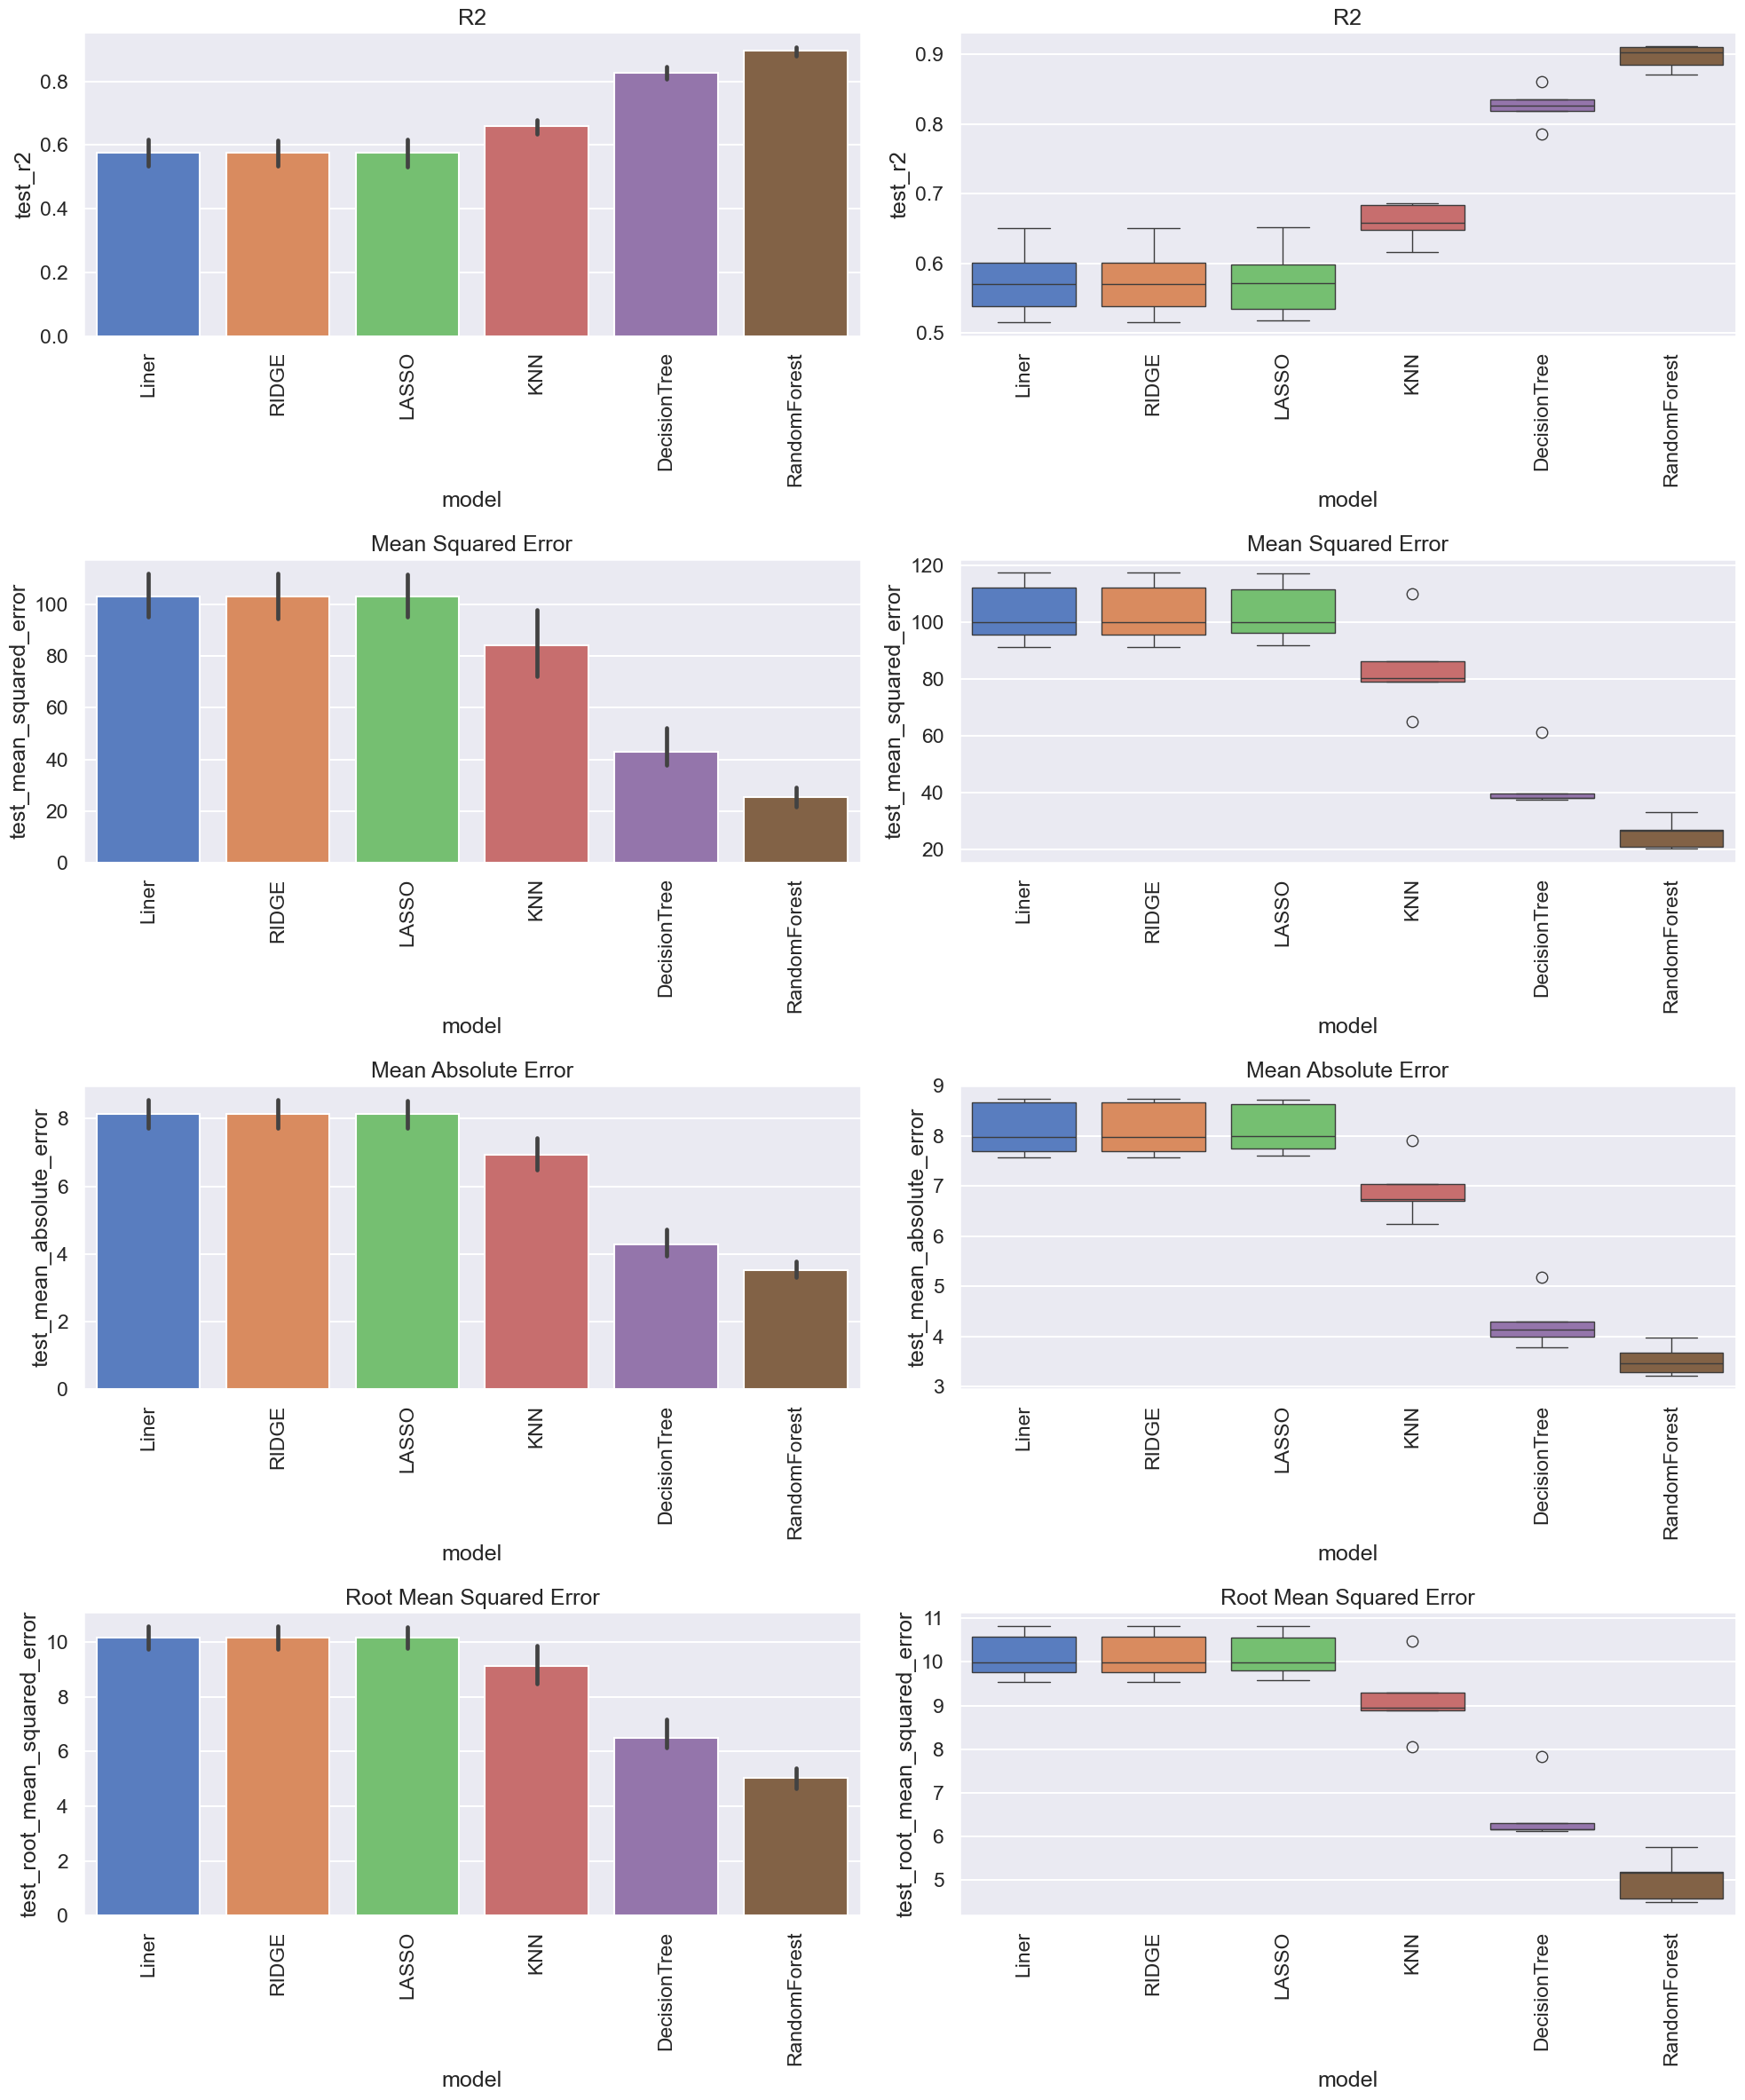

In [43]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 24))



sns.barplot(y = 'test_r2', x='model', data=result_df, hue='model',palette = "muted", ax=axes[0][0])
axes[0][0].set_title("R2")
axes[0][0].tick_params(axis="x", rotation=90)

sns.boxplot(y = 'test_r2', x='model', data=result_df, hue='model',palette = "muted", ax=axes[0][1])
axes[0][1].set_title("R2")
axes[0][1].tick_params(axis="x", rotation=90)

sns.barplot(y = 'test_mean_squared_error', x='model', data=result_df, hue='model',palette = "muted",  ax=axes[1][0])
axes[1][0].set_title("Mean Squared Error")
axes[1][0].tick_params(axis="x", rotation=90)

sns.boxplot(y = 'test_mean_squared_error', x='model', data=result_df, hue='model',palette = "muted", ax=axes[1][1])
axes[1][1].set_title("Mean Squared Error")
axes[1][1].tick_params(axis="x", rotation=90)

sns.barplot(y = 'test_mean_absolute_error', x='model', data=result_df, hue='model',palette = "muted",  ax=axes[2][0])
axes[2][0].set_title("Mean Absolute Error")
axes[2][0].tick_params(axis="x", rotation=90)

sns.boxplot(y = 'test_mean_absolute_error', x='model', data=result_df, hue='model',palette = "muted", ax=axes[2][1])
axes[2][1].set_title("Mean Absolute Error")
axes[2][1].tick_params(axis="x", rotation=90)

sns.barplot(y = 'test_root_mean_squared_error', x='model', data=result_df, hue='model',palette = "muted",  ax=axes[3][0])
axes[3][0].set_title("Root Mean Squared Error")
axes[3][0].tick_params(axis="x", rotation=90)


sns.boxplot(y = 'test_root_mean_squared_error', x='model', data=result_df, hue='model',palette = "muted", ax=axes[3][1])
axes[3][1].set_title("Root Mean Squared Error")
axes[3][1].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

## Feature Importance 

### Linear Model

<Axes: xlabel='importance', ylabel='feature_name'>

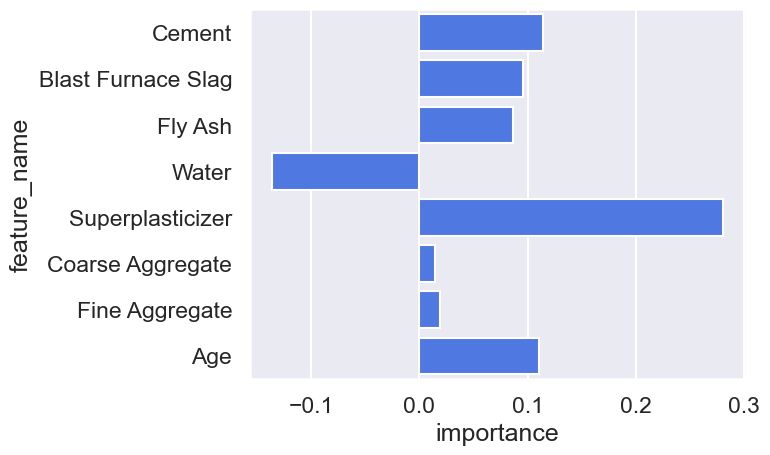

In [62]:
### Linear Model
model = LinearRegression()
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.coef_, "feature_name":model.feature_names_in_})

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)

### Ridge

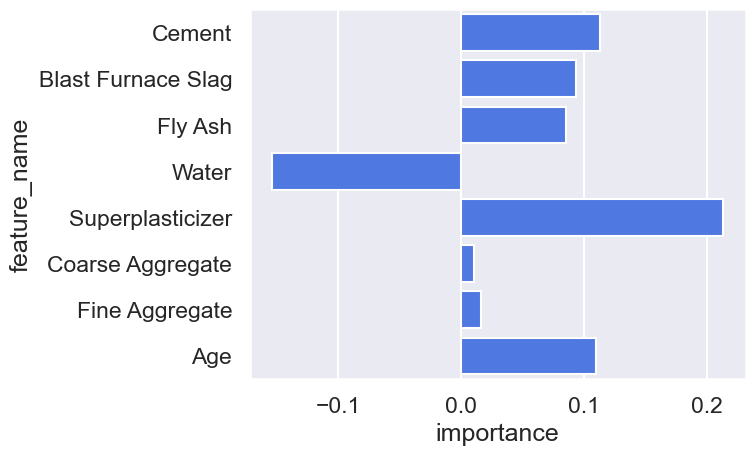

In [63]:
### Linear Model
model = Lasso(random_state=43)
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.coef_, "feature_name":model.feature_names_in_})

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)

### Lasso

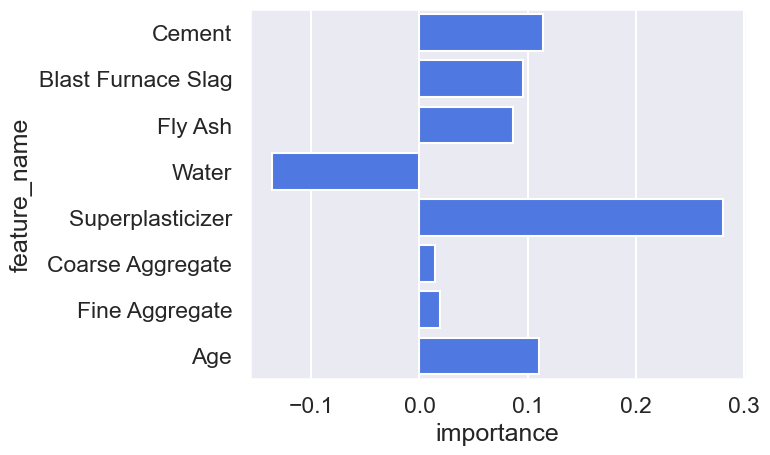

In [64]:
### Linear Model
model = Ridge(random_state=43)
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.coef_, "feature_name":model.feature_names_in_})

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)

### Decession Tree

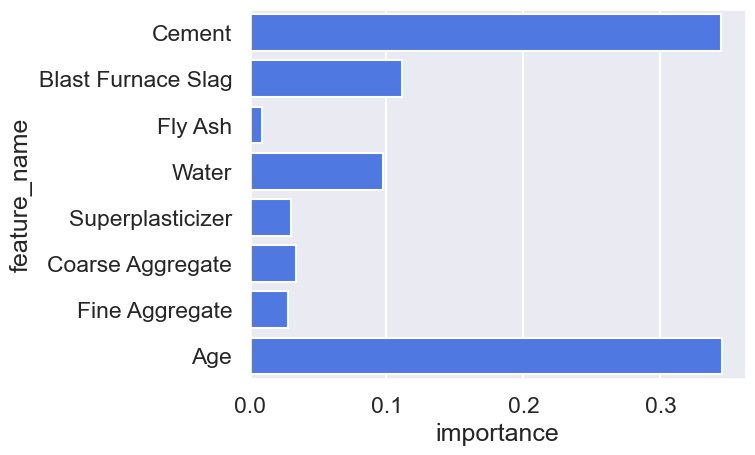

In [65]:
### Linear Model
model = DecisionTreeRegressor(random_state=43)
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.feature_importances_, "feature_name":model.feature_names_in_})

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)

### Random Forest

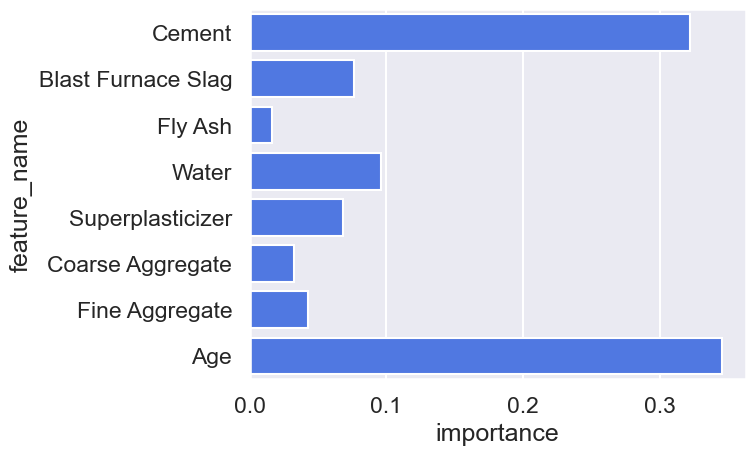

In [67]:
### Linear Model
model = RandomForestRegressor(random_state=43)
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.feature_importances_, "feature_name":model.feature_names_in_})

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)